# Workflow to compare TISSUES and NextProt data

### Import the required packages

In [1]:
## based on the tutorial https://jensenlab.org/training/stringapp/#exercise-3

import os
import sys
from time import sleep
import pandas as pd
import matplotlib
from py2cytoscape import cyrest
from IPython.display import Image
%matplotlib inline

### Setup Cytoscape
TODO: check if apps are installed and if not, install them

In [6]:
cytoscape=cyrest.cyclient()
cytoscape.version()

(u'cytoscapeVersion', u'3.7.2')
(u'apiVersion', u'v1')


In [7]:
cytoscape.session.new()

### Protein network retrieval
Retrieve a STRING network for all UniProt identifiers in the table. 

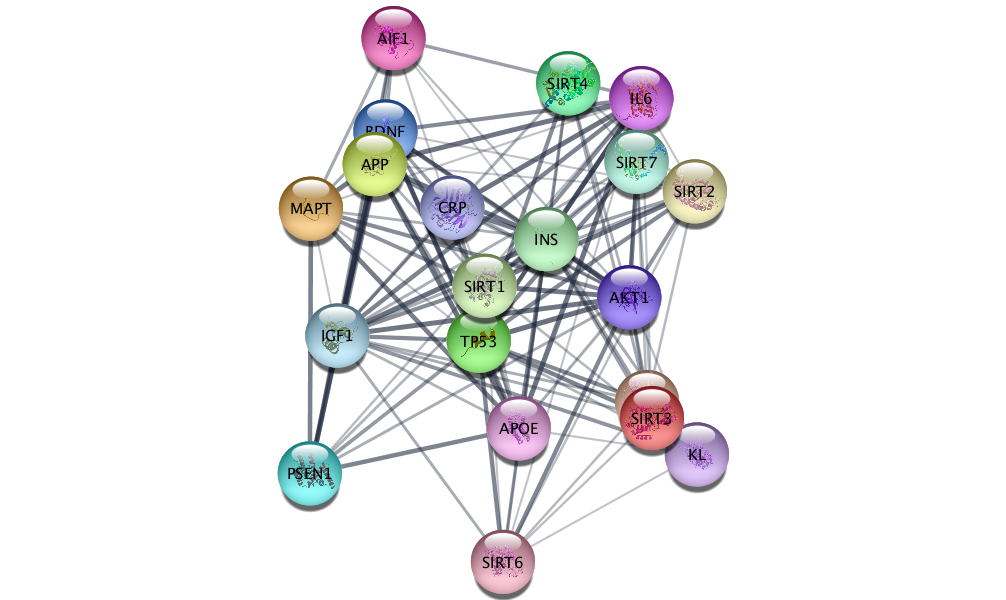

In [8]:
from py2cytoscape.cyrest.base import api
## create the string network with the uniprot ids
api(namespace="string",command="pubmed query",PARAMS={"cutoff": "0.4",
                                                      "limit": "20",
                                                      "pubmed": "aging",
                                                      "species": "homo sapiens",
                                                      "taxonID": "9606"})
sleep(2)
fig=cytoscape.networks.getFirstImageAsPng(networkId=cytoscape.network.get()["SUID"],h=None)
Image(fig.content)

### Check for obsolete UniProt IDs

In [27]:
## get list 
uniprotIDs=list(set(cytoscape.table.getTable(columns=['stringdb::canonical name'],table='node')['stringdb::canonical name']))

In [28]:
## convert from STRING UniProt IDs to current IDs / check for obsolete IDs
import urllib,urllib2
url = "https://www.uniprot.org/uploadlists/"
params = {
"from":"ACC",
"to":"ACC",
"format":"tab",
"query":' '.join(uniprotIDs)
}
data = urllib.urlencode(params)
request = urllib2.Request(url, data)
contact = "" # Please set a contact email address here to help us debug in case of problems (see https://www.uniprot.org/help/privacy).
request.add_header("User-Agent", "Python %s" % contact)
response = urllib2.urlopen(request)
page = response.read(200000)

In [30]:
from io import StringIO 
StringData = StringIO(unicode(page))
uniprot_mapping = pd.read_csv(StringData, sep ="\t")
uniprot_mapping.head()

,From,To
0,P55008,P55008
1,P02649,P02649
2,P31749,P31749
3,Q5CZI7,P10636
4,P05231,P05231


### Get NextProt data

### Convert NextProt data and merge with TISSUES
Create an OmicsVisualizer table

### Save the session

In [27]:
cytoscape.session.save_as(session_file="tissues_nextprot_merge")